In [2]:
# Imports.
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tfd = tf.contrib.distributions


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
# Model & Plotting.

# Encoder.
def make_encoder(data, code_size):
    x = tf.layers.flatten(data)
    h1 = tf.layers.dense(x, 256, tf.nn.relu)
    h2 = tf.layers.dense(h1, 256, tf.nn.relu)
    loc = tf.layers.dense(h2, code_size)
    scl = tf.layers.dense(h2, code_size, tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scl)

# Prior.
def make_prior(code_size):
    loc = tf.zeros(code_size)
    scl = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scl)

# Decoder
def make_decoder(code, data_shape):
    x = code
    h1 = tf.layers.dense(x, 256, tf.nn.relu)
    h2 = tf.layers.dense(h1, 256, tf.nn.relu)
    loc = tf.layers.dense(h2, np.prod(data_shape), tf.nn.tanh)
    scl = tf.layers.dense(h2, np.prod(data_shape), tf.nn.softmax)
    
    return loc, scl

# Plotting.
def plot(epoch, codes, labels, samples, size=1):
    ig, ax = plt.subplots(ncols=1 + len(samples), figsize=((1 + len(samples)) * size, size))
    no_ticks = dict(left='off', bottom='off', labelleft='off', labelbottom='off')
    ax[0].set_ylabel('Epoch {}'.format(epoch))
    ax[0].scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
    ax[0].set_aspect('equal')
    ax[0].set_xlim(codes.min() - .1, codes.max() + .1)
    ax[0].set_ylim(codes.min() - .1, codes.max() + .1)
    ax[0].tick_params(axis='both', which='both', **no_ticks)
    for index, sample in enumerate(samples):
        ax[1 + index].imshow(sample, cmap='gray')
        ax[1 + index].tick_params(axis='both', which='both', **no_ticks)
    plt.show()

# Optimisation
make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

In [4]:
# Dataset retrieval.
mnist = tf.keras.datasets.mnist.load_data()
train = mnist[0]
test = mnist[1]

# Training set (normalized)
X_train = train[0]/255
y_train = train[1]

# Test set (normalized)
X_test = test[0]/255
y_test = test[1]

In [5]:
data = tf.placeholder(tf.float32, [None, 28, 28])

# Define the model.
prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

# Define the loss.
loc, scl = make_decoder(code, [28, 28])

mvn = tfd.MultivariateNormalDiag(loc, scl)
likelihood = mvn.log_prob(tf.reshape(data, [-1, 784]))

divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlo

Epoch 0 elbo -27629552.0


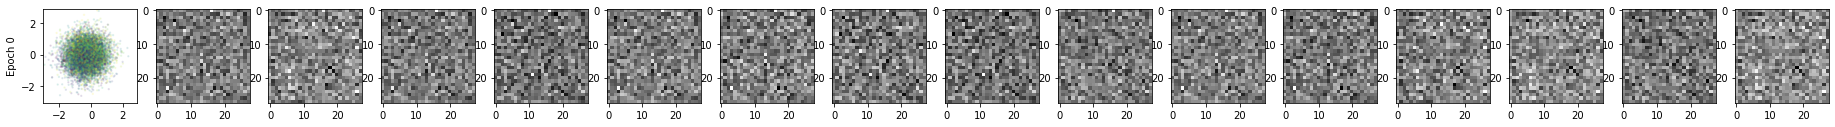

Epoch 1 elbo -3640356.8


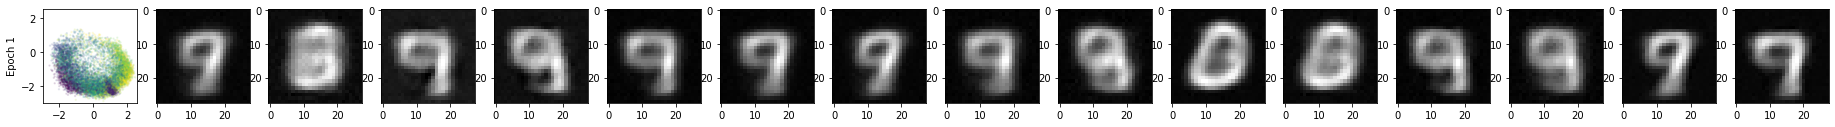

Epoch 2 elbo -3117181.8


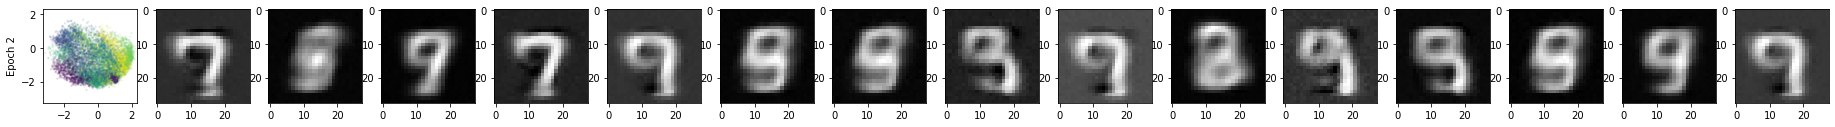

Epoch 3 elbo -2841933.8


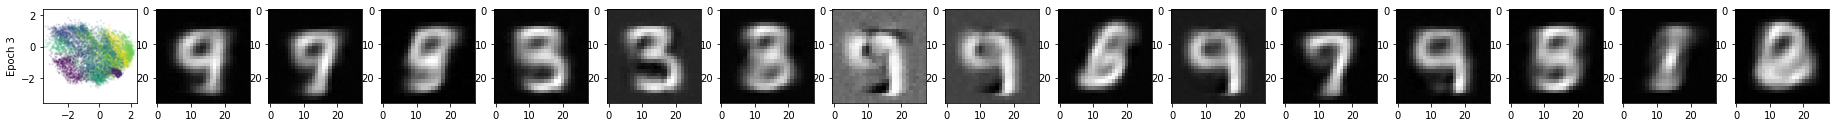

Epoch 4 elbo -2709262.8


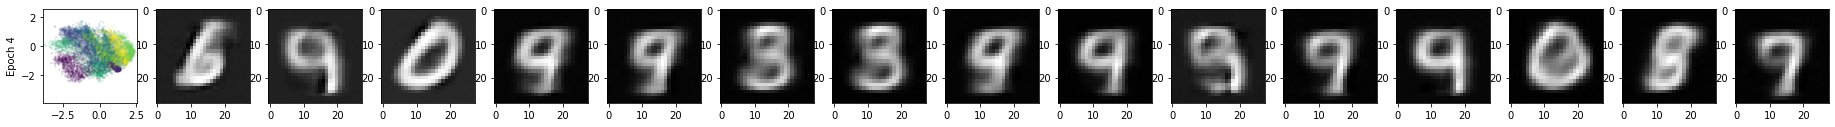

Epoch 5 elbo -2660183.8


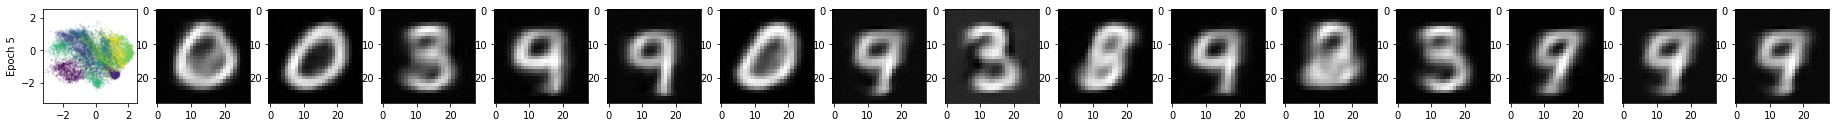

Epoch 6 elbo -2573481.2


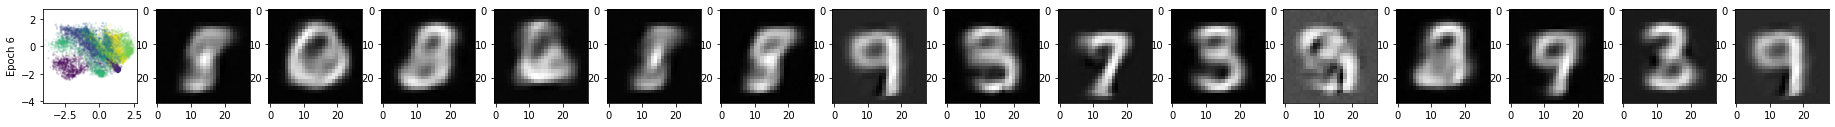

Epoch 7 elbo -2498815.5


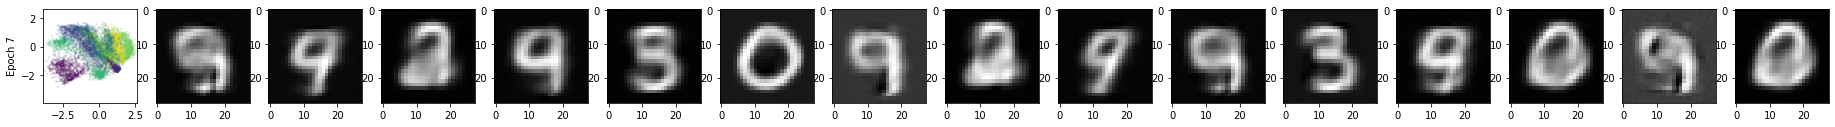

Epoch 8 elbo -2711722.8


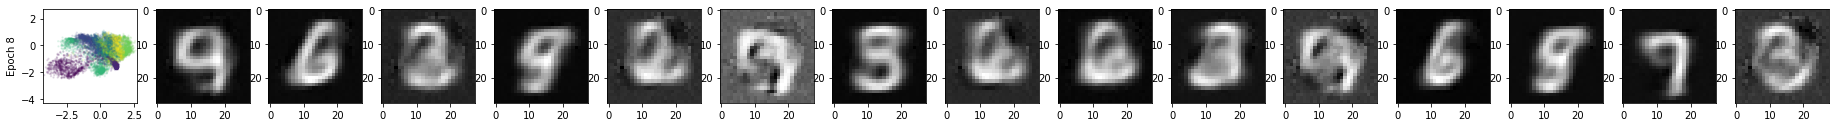

Epoch 9 elbo -2466871.8


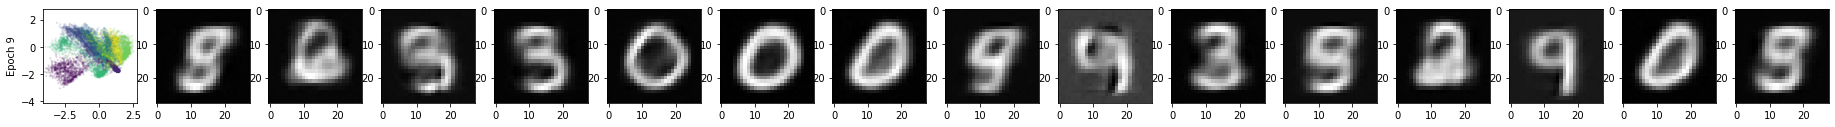

Epoch 10 elbo -2447893.0


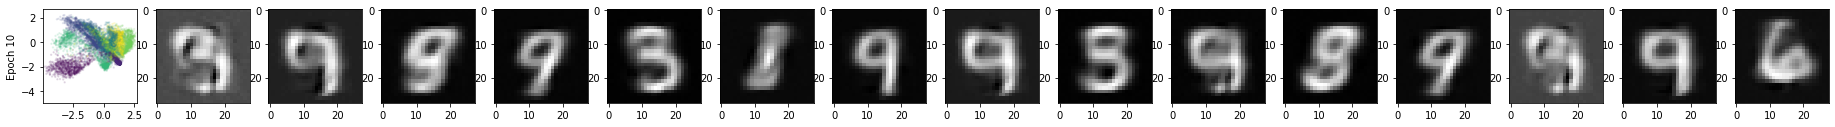

Epoch 11 elbo -2371351.2


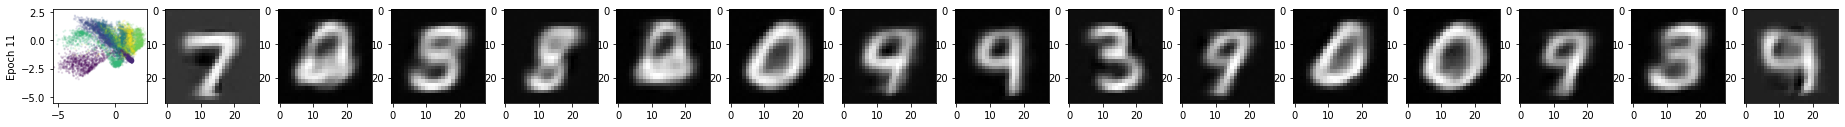

Epoch 12 elbo -2406617.0


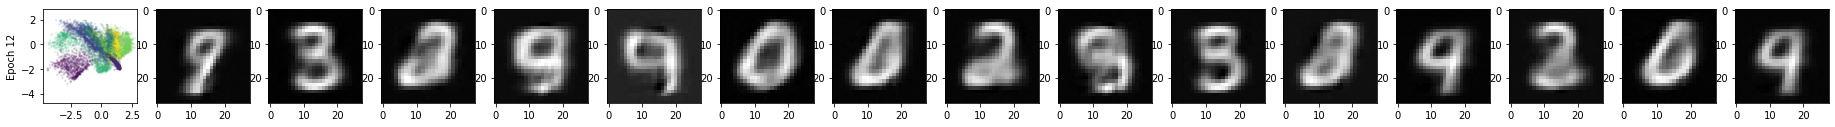

Epoch 13 elbo -2276413.8


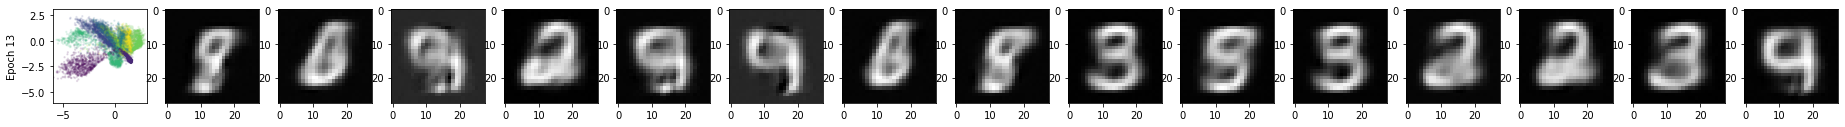

Epoch 14 elbo -2288902.5


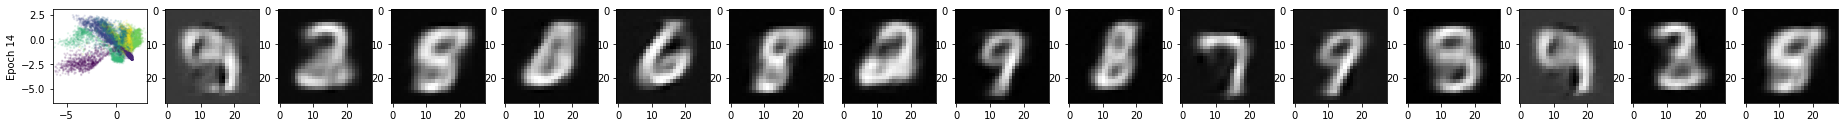

Epoch 15 elbo -2216080.8


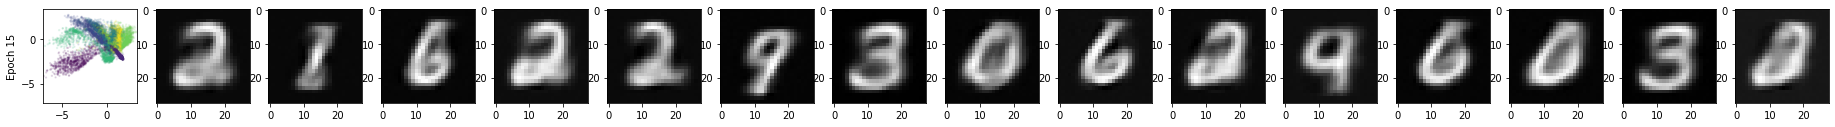

Epoch 16 elbo -2258192.8


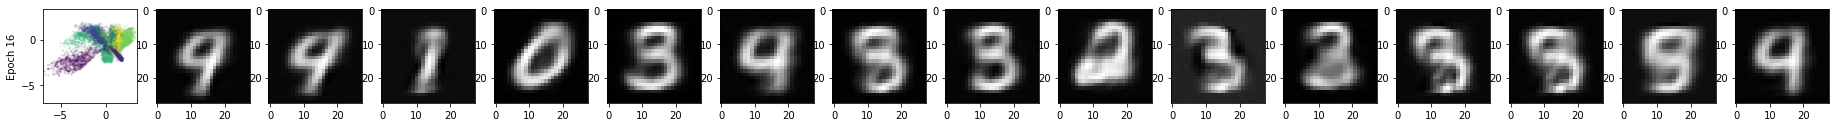

Epoch 17 elbo -2204173.5


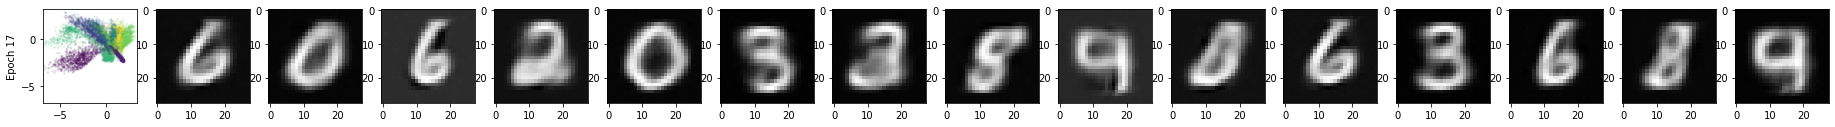

Epoch 18 elbo -2185581.8


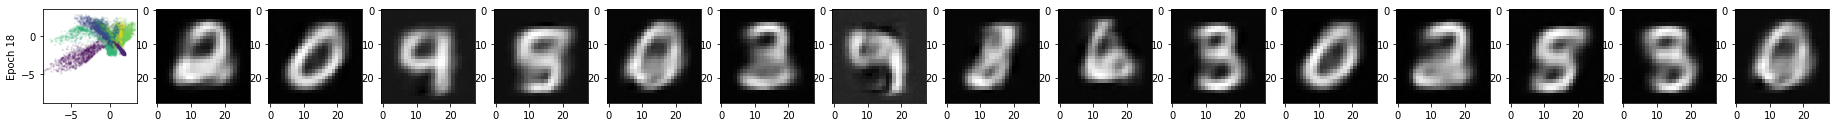

Epoch 19 elbo -2147100.8


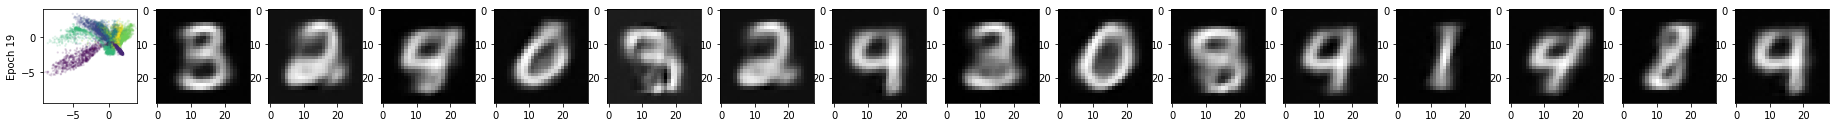

Epoch 20 elbo -2134723.5


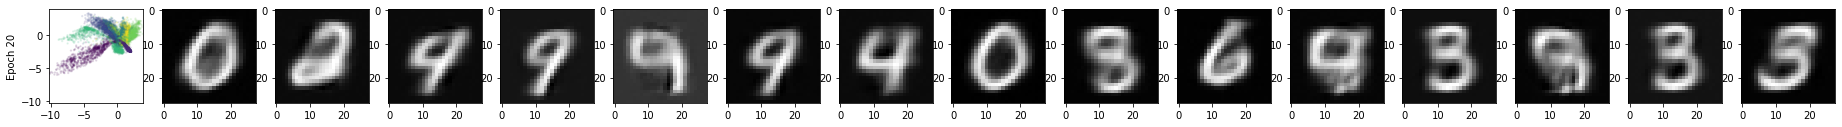

Epoch 21 elbo -2097883.2


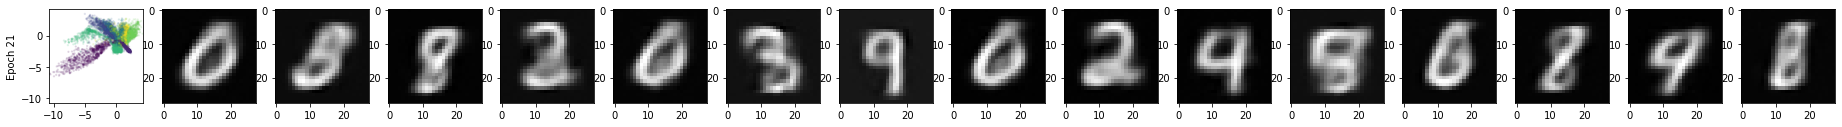

Epoch 22 elbo -2103006.0


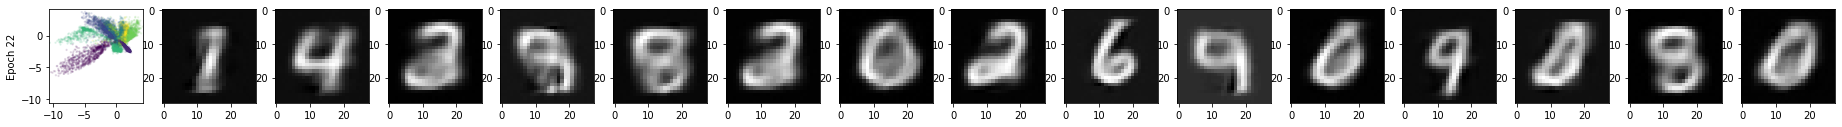

Epoch 23 elbo -2084080.0


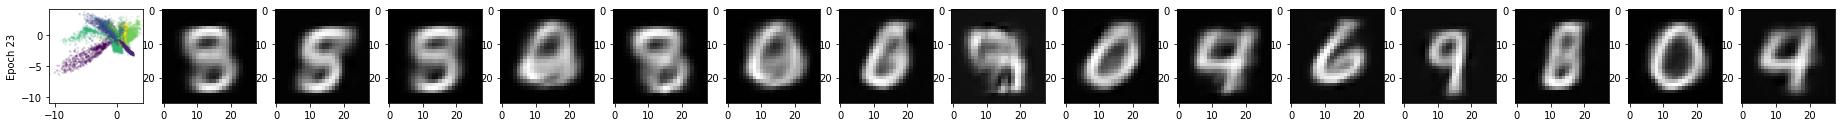

Epoch 24 elbo -2083924.0


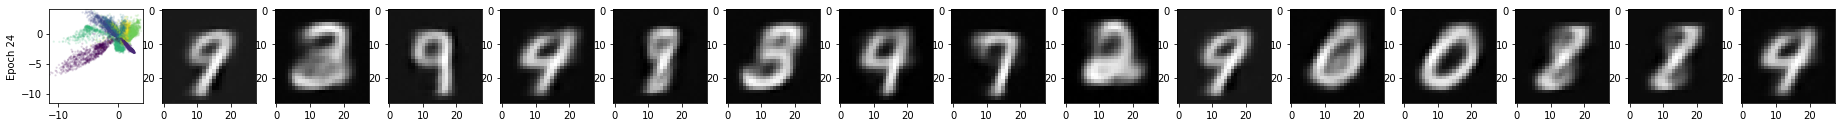

Epoch 25 elbo -2097658.2


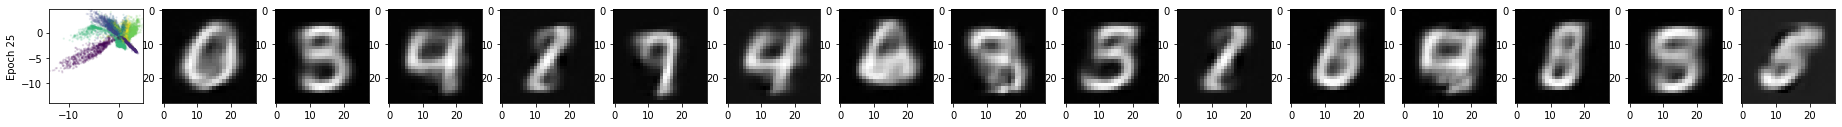

Epoch 26 elbo -2088317.5


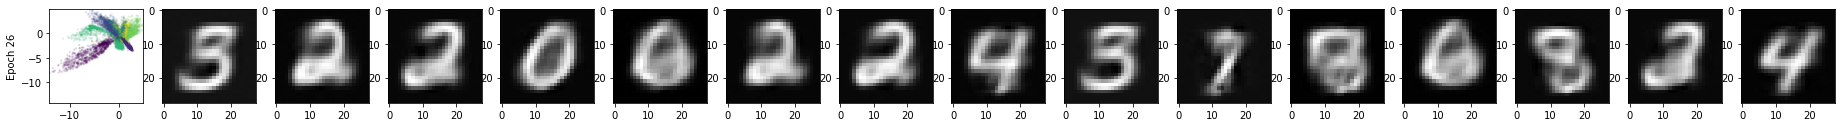

Epoch 27 elbo -2064541.9


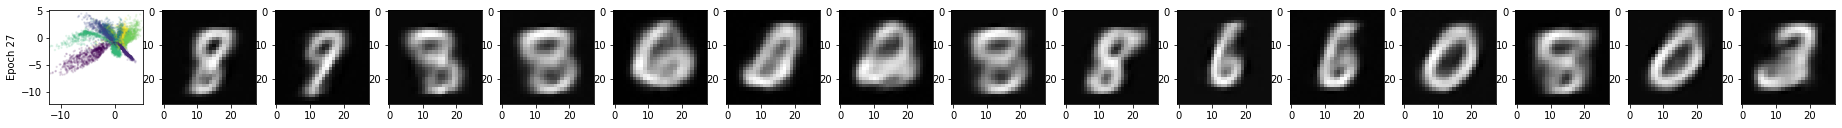

Epoch 28 elbo -2105571.2


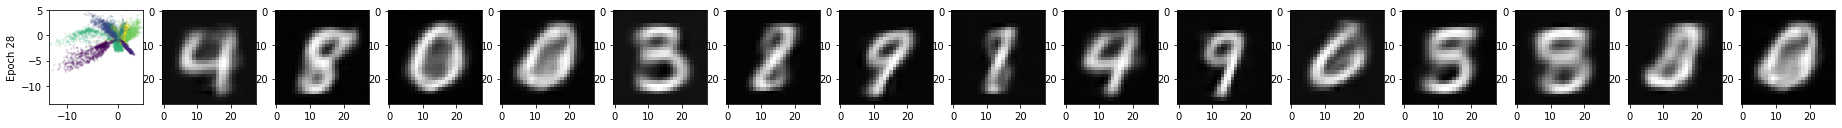

Epoch 29 elbo -2074985.2


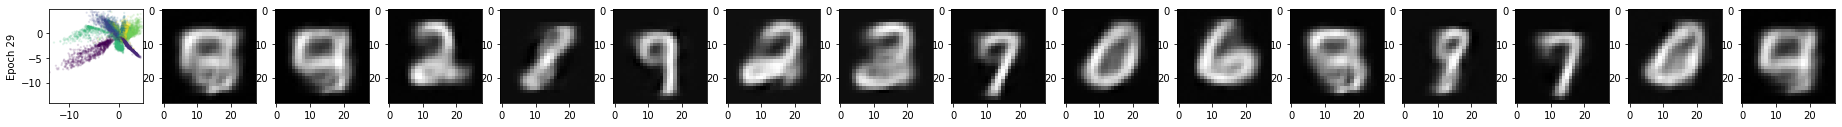

Epoch 30 elbo -2251634.8


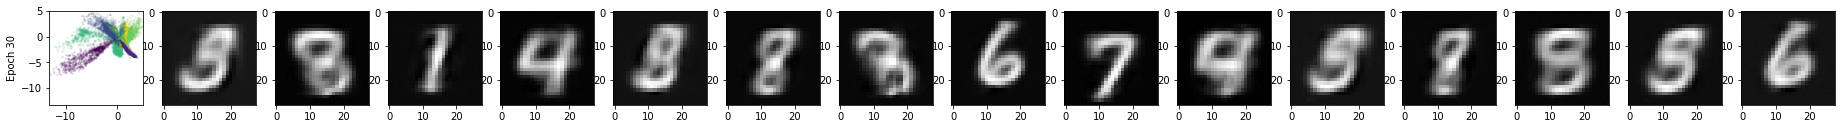

Epoch 31 elbo -2120977.2


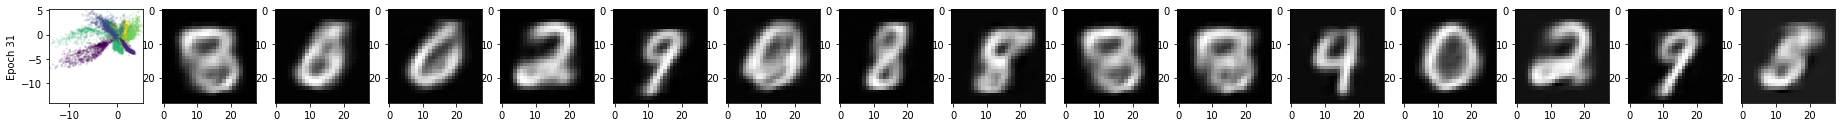

Epoch 32 elbo -2070862.6


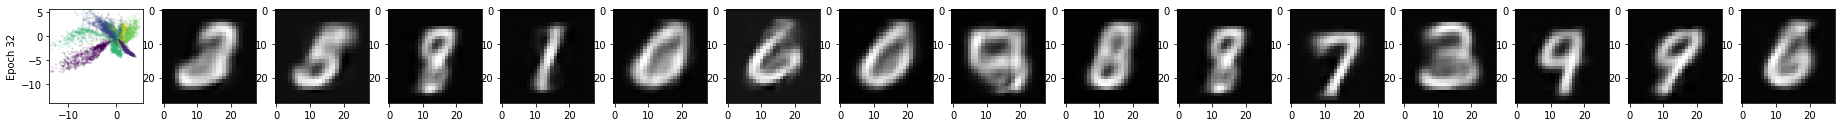

Epoch 33 elbo -2141258.5


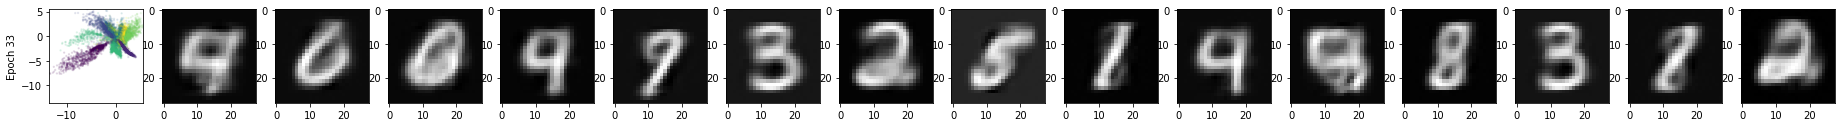

Epoch 34 elbo -2130752.8


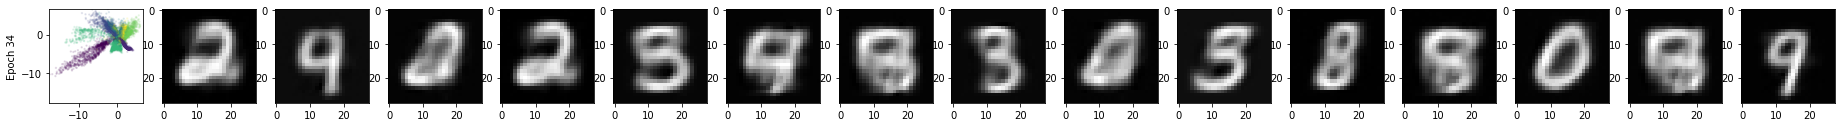

Epoch 35 elbo -2096893.8


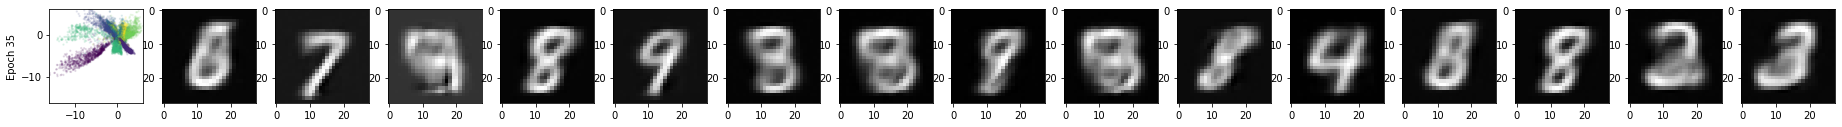

Epoch 36 elbo -2138007.5


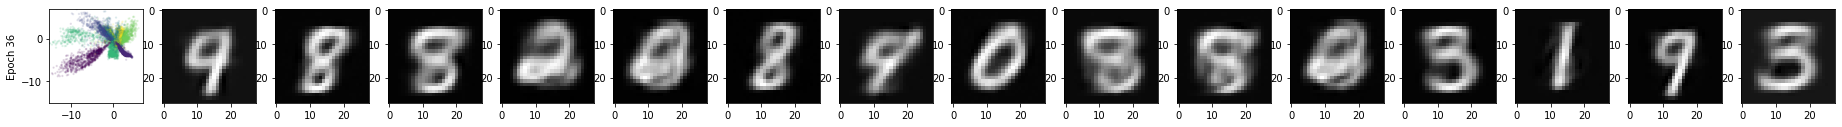

Epoch 37 elbo -2175634.0


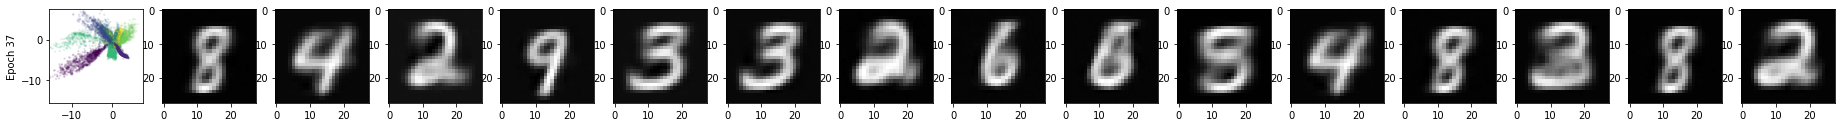

Epoch 38 elbo -2260217.5


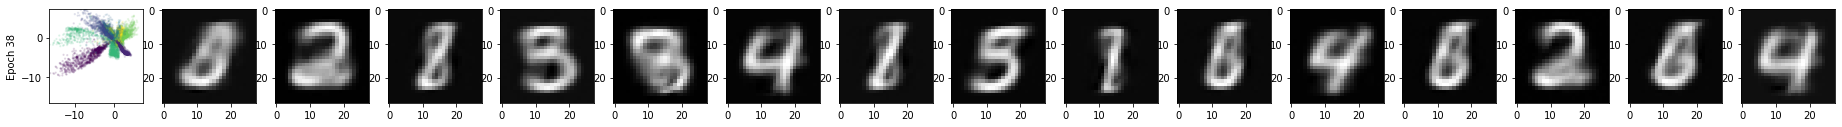

Epoch 39 elbo -2359018.8


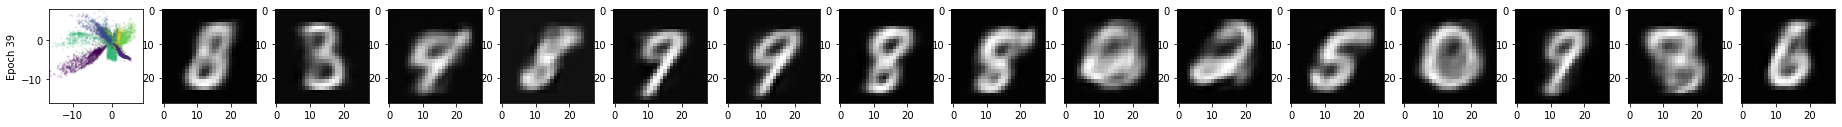

Epoch 40 elbo -2164847.5


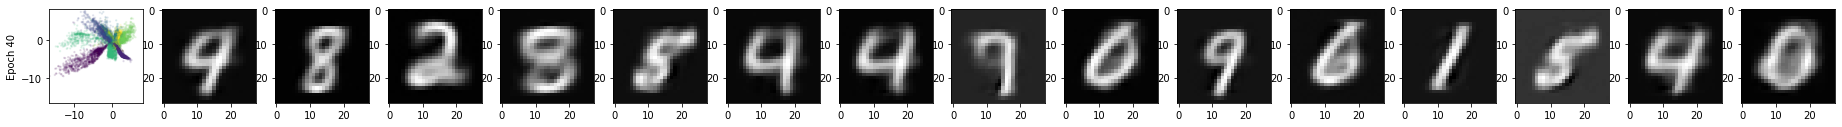

Epoch 41 elbo -2226191.2


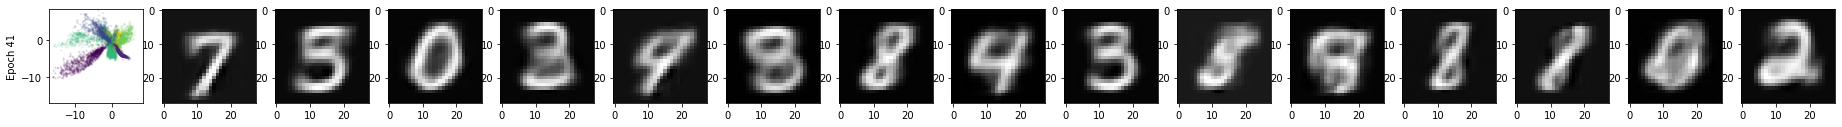

Epoch 42 elbo -2241530.0


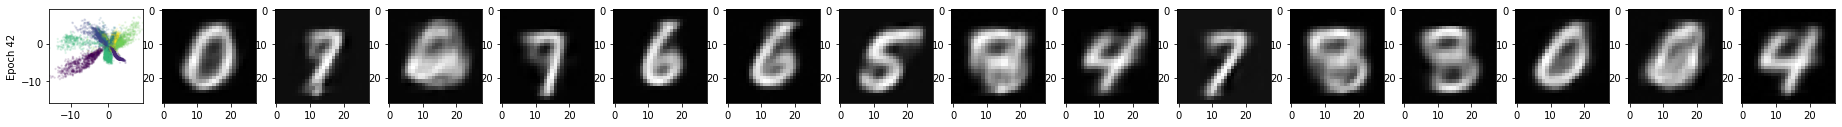

Epoch 43 elbo -2171122.8


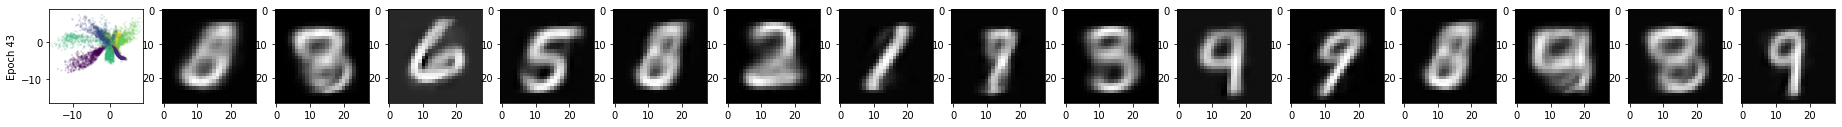

Epoch 44 elbo -2166819.8


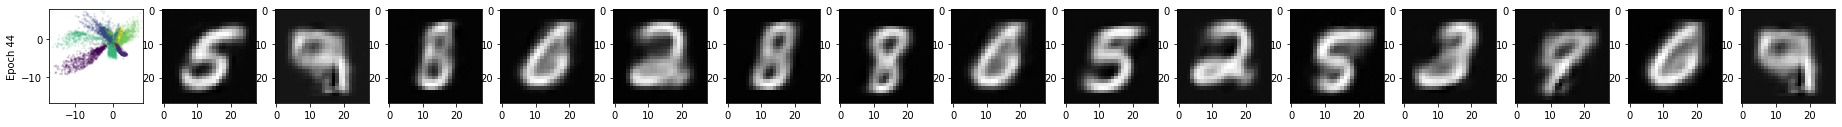

Epoch 45 elbo -2341796.5


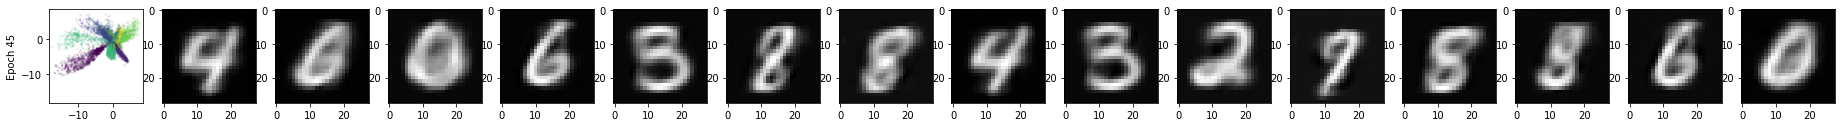

Epoch 46 elbo -2137221.8


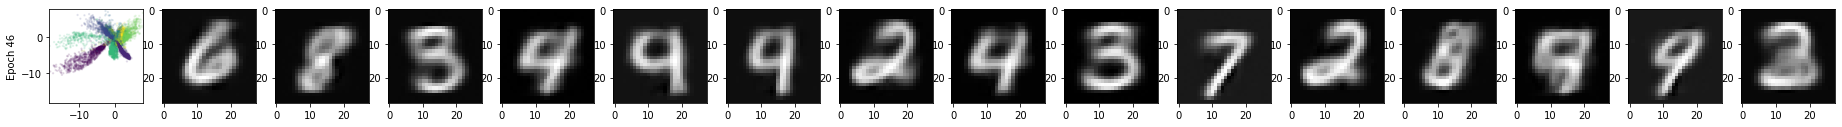

Epoch 47 elbo -2189804.8


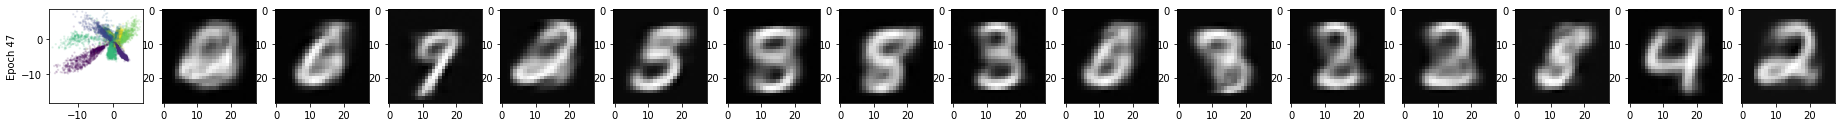

Epoch 48 elbo -2183692.2


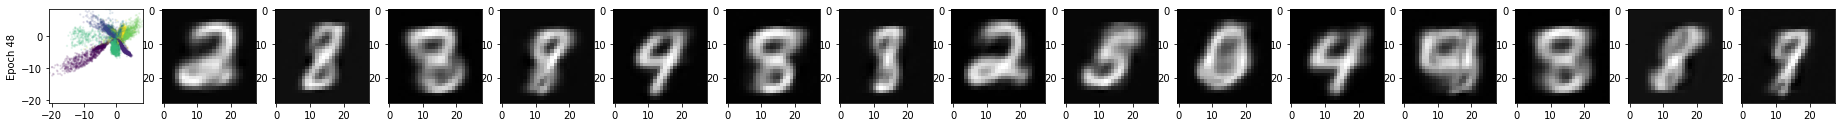

Epoch 49 elbo -2138970.0


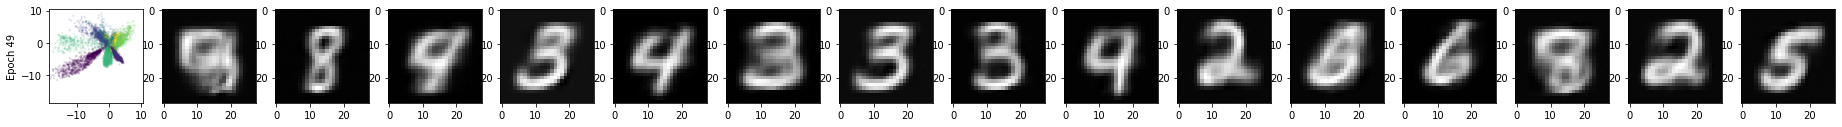

Epoch 50 elbo -2229613.2


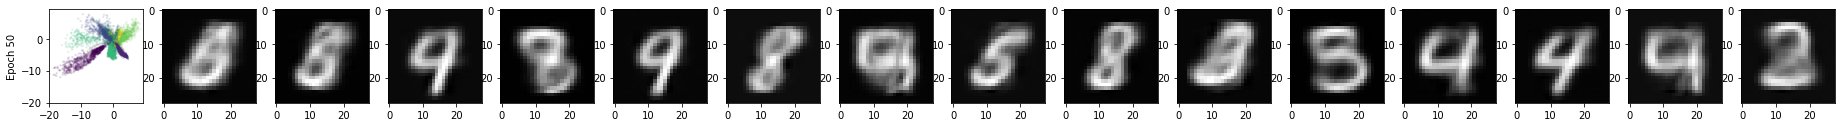

Epoch 51 elbo -2247344.2


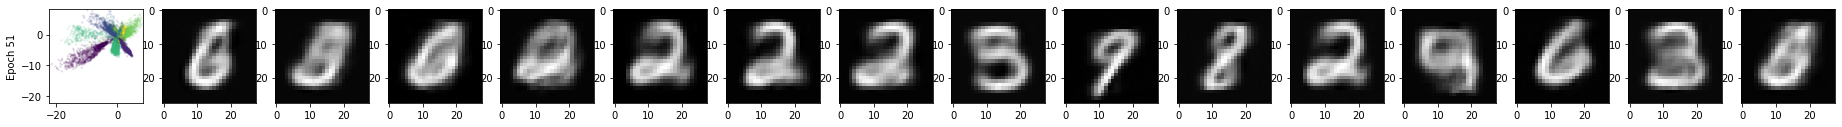

Epoch 52 elbo -2288548.2


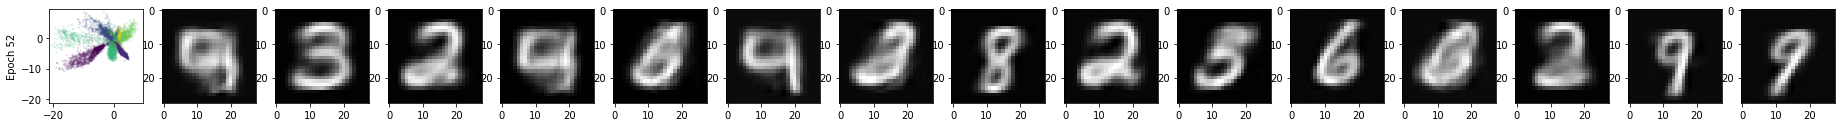

Epoch 53 elbo -2336963.0


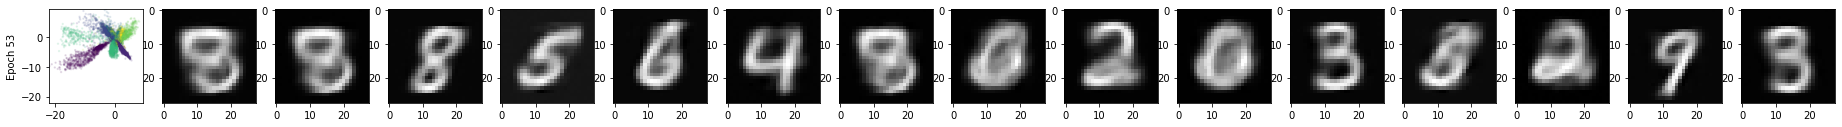

Epoch 54 elbo -2257179.0


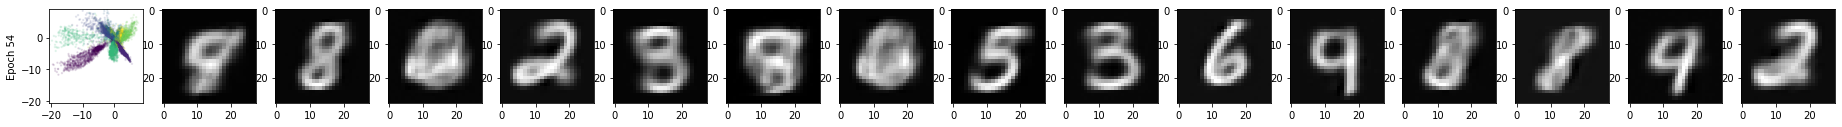

Epoch 55 elbo -2906600.8


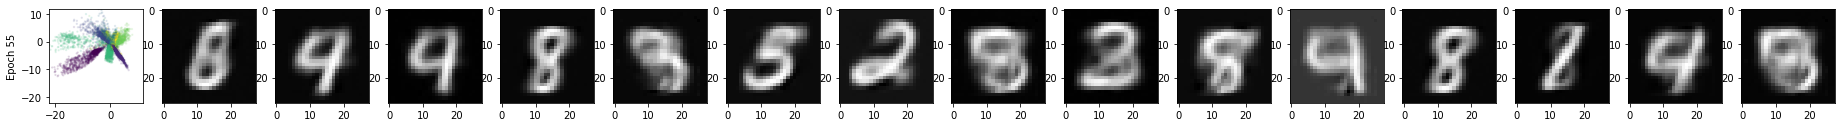

Epoch 56 elbo -2387475.2


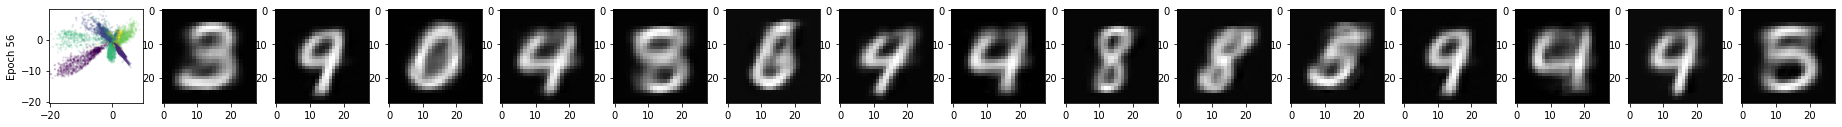

Epoch 57 elbo -2552446.2


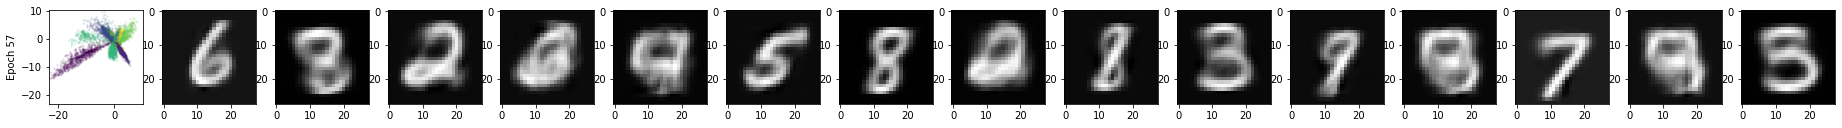

Epoch 58 elbo -2225811.2


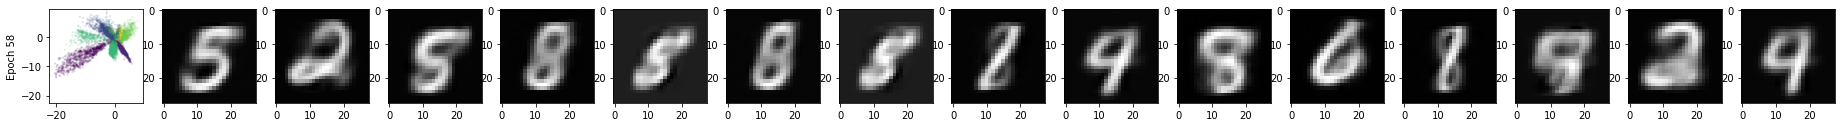

Epoch 59 elbo -2378456.5


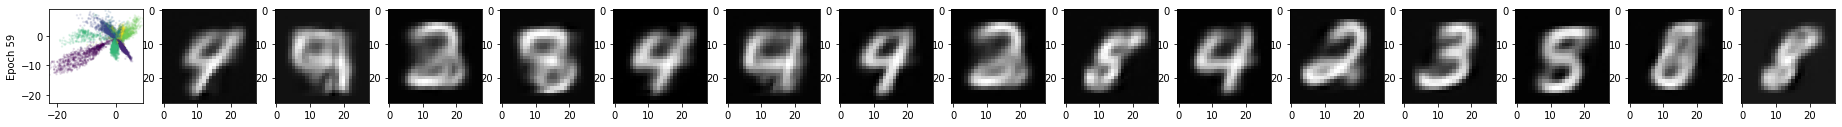

In [7]:
samples, _ = make_decoder(prior.sample(15), [28, 28])

elbos = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(60):
        test_elbo, test_codes, test_samples, test_loc = sess.run([elbo, code, samples, loc], {data: X_test})
        elbos.append(test_elbo)
        print('Epoch', epoch, 'elbo', test_elbo)
        test_samples = test_samples.reshape((-1,28,28))
        
        if epoch == 1: 
            codes1 = test_codes
            recon1 = test_loc.reshape((-1,28,28))
            gener1 = test_samples
        
        if epoch == 5:
            codes5 = test_codes
            recon5 = test_loc.reshape((-1,28,28))
            gener5 = test_samples
        
        if epoch == 25:
            codes25 = test_codes
            recon25 = test_loc.reshape((-1,28,28))
            gener25 = test_samples
        
        if epoch == 50:
            codes50 = test_codes
            recon50 = test_loc.reshape((-1,28,28))
            gener50 = test_samples
        
        plot(epoch, test_codes, y_test, test_samples, size=2)
        for _ in range(600):
            indices = np.random.choice(X_train.shape[0], 128)
            batch = X_train[indices]
            sess.run(optimize, {data: batch})

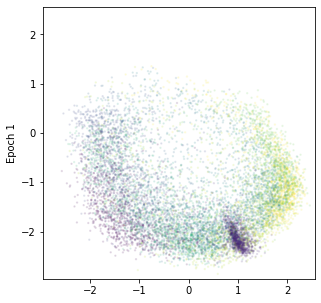

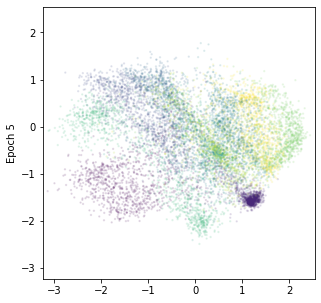

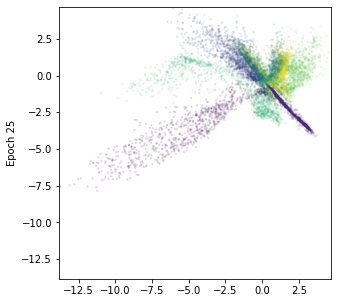

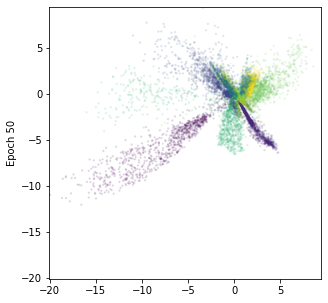

In [12]:
# Latent representations
def plot_ltnt(epoch, codes, labels, size=5):
    ig, ax = plt.subplots(ncols=1, figsize=(size, size))
    no_ticks = dict(left='off', bottom='off', labelleft='off', labelbottom='off')
    ax.set_ylabel('Epoch {}'.format(epoch))
    ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
    ax.set_aspect('equal')
    ax.set_xlim(codes.min() - .1, codes.max() + .1)
    ax.set_ylim(codes.min() - .1, codes.max() + .1)
    ax.tick_params(axis='both', which='both', **no_ticks)
    plt.show()
    
plot_ltnt(1, codes1, y_test)
plot_ltnt(5, codes5, y_test)
plot_ltnt(25, codes25, y_test)
plot_ltnt(50, codes50, y_test)

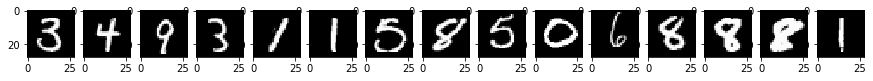

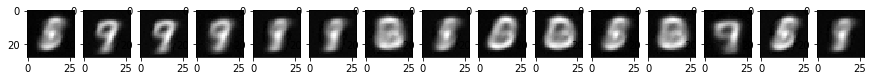

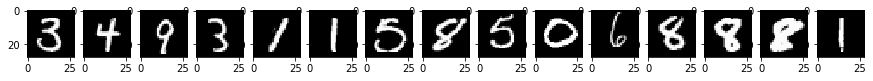

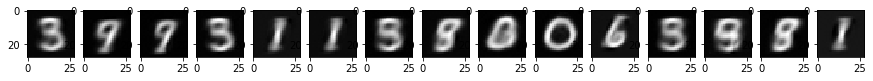

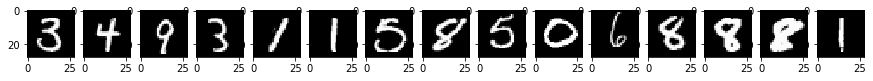

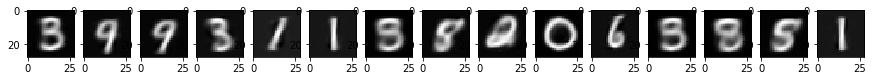

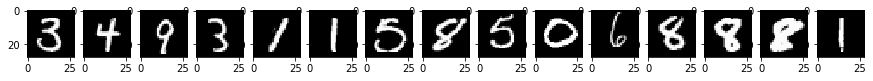

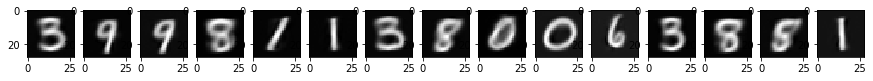

In [21]:
# Reconstructed images. 
def plot_imgs(imgs, size=1):
    ig, ax = plt.subplots(ncols=len(imgs), figsize=(len(imgs) * size, size))
    no_ticks = dict(left='off', bottom='off', labelleft='off', labelbottom='off')
    for index, img in enumerate(imgs):
        ax[index].imshow(img, cmap='gray')
        ax[index].tick_params(axis='both', which='both', **no_ticks)
    plt.show()
    

indices = np.random.choice(X_test.shape[0], 15, replace=False)

real = X_test[indices]

reco1 = recon1[indices]
plot_imgs(real)
plot_imgs(reco1)

reco5 = recon5[indices]
plot_imgs(real)
plot_imgs(reco5)

reco25 = recon25[indices]
plot_imgs(real)
plot_imgs(reco25)

reco50 = recon50[indices]
plot_imgs(real)
plot_imgs(reco50)

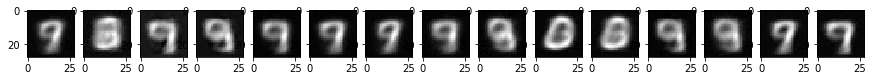

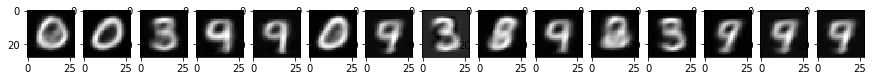

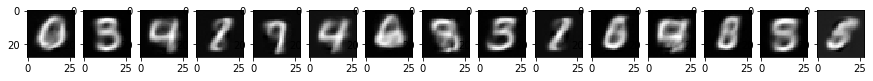

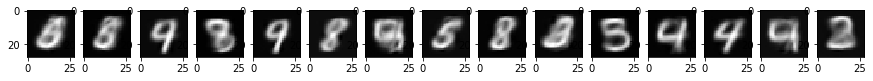

In [14]:
# Generated digits.
plot_imgs(gener1)
plot_imgs(gener5)
plot_imgs(gener25)
plot_imgs(gener50)

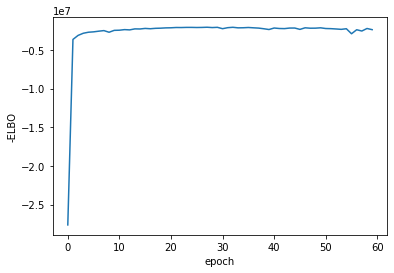

In [22]:
# Loss curve
sub = plt.subplot()
sub.plot(range(len(elbos)), elbos)
sub.set_xlabel('epoch')
sub.set_ylabel('-ELBO')
plt.show()